# Hypothesis Testing by Bootstrapping

We will look into the classical example given by Efron, for establishing CI for correlation within small data.


In [ ]:
import pandas as pd
import seaborn as sns

data = {
    "LSAT": [576, 635, 558, 578, 666, 580, 555, 661, 651, 605, 653, 575, 545, 572, 594],
    "GPA": [3.39, 3.30, 2.81, 3.03, 3.44, 3.07, 3.00, 3.43, 3.36, 3.13, 3.12, 2.74, 2.76, 2.88, 2.96]
}

df = pd.DataFrame(data)
df.head()

,LSAT,GPA
0,576,3.39
1,635,3.30
2,558,2.81
3,578,3.03
4,666,3.44


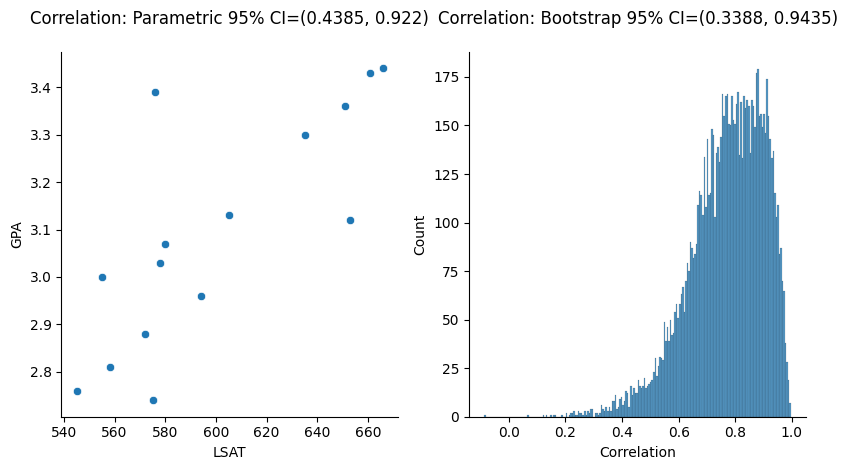

In [ ]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt


fig,axs = plt.subplots(1,2)


ax = axs[0]
sns.scatterplot(data=df, x="LSAT", y="GPA",ax=ax)
res = stats.pearsonr( df["LSAT"],df["GPA"] )
CI = res.confidence_interval()
CI = CI.low.round(4), CI.high.round(4)

ax.set_title(f"Correlation: Parametric 95% CI={CI}",pad=20)


ax = axs[1]

def fn(x,y):
  return np.corrcoef(x,y)[0,1]  #stats.pearsonr(x,y)[0]

# NOTE: see https://github.com/scipy/scipy/blob/v1.12.0/scipy/stats/_stats_py.py#L4385

res = stats.bootstrap((df["LSAT"],df["GPA"]),fn,paired=True)
CI = res.confidence_interval.low.round(4),res.confidence_interval.high.round(4)


sns.histplot(res.bootstrap_distribution,bins=200,ax=ax)
ax.set_xlabel("Correlation")
ax.set_title(f"Correlation: Bootstrap 95% CI={CI}",pad=20)


sns.despine(fig)

fig.tight_layout(rect=[0, 0, 1.3, 1])
plt.show()

# Regression Estimation

They say "time is money" but does money gain time? We will look how healt expentditues impact the life expactancy.

**Homework** Use regression to estimate the `year / USD` relation. Compute CI estimates for each country slope, by theoretical and bootstrap methods.

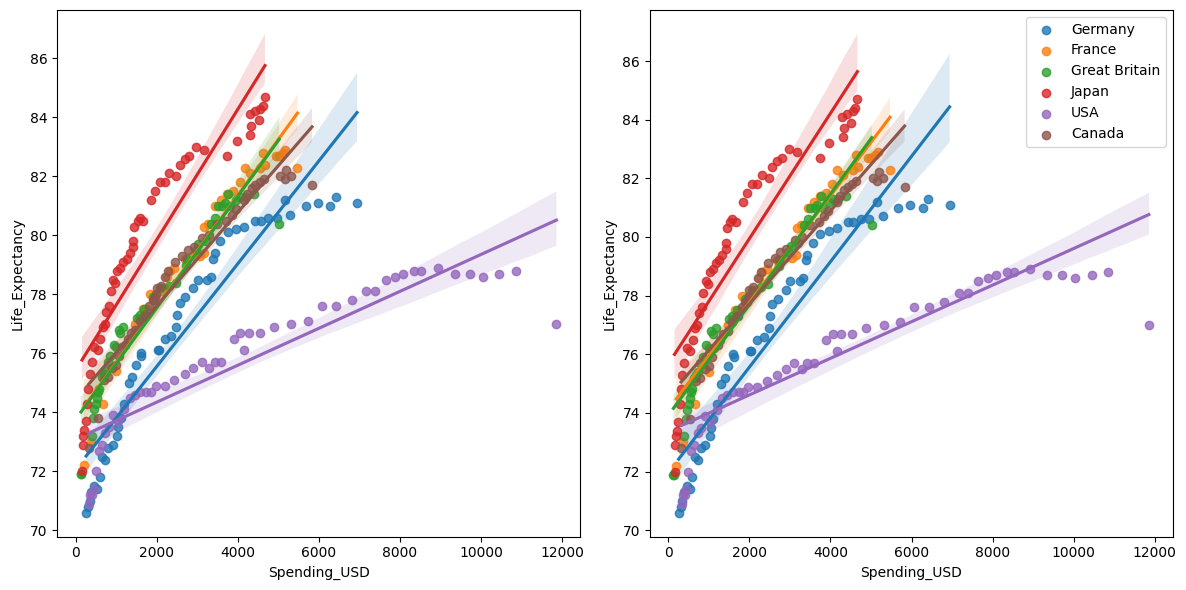

In [ ]:
healthexp = sns.load_dataset("healthexp").sort_values("Year")

fig,axs = plt.subplots(1,2,figsize=(12,6))

ax = axs[0]

for country in healthexp['Country'].unique():
  mask = healthexp['Country'] == country
  sns.regplot(    data=healthexp[mask],
      x="Spending_USD", y="Life_Expectancy", ax=ax, label=country, robust=False,
  )

ax = axs[1]
for country in healthexp['Country'].unique():
  mask = healthexp['Country'] == country
  sns.regplot(    data=healthexp[mask],
      x="Spending_USD", y="Life_Expectancy", ax=ax, label=country, robust=True,
  )

plt.legend()
plt.tight_layout()
plt.show()

### Homework

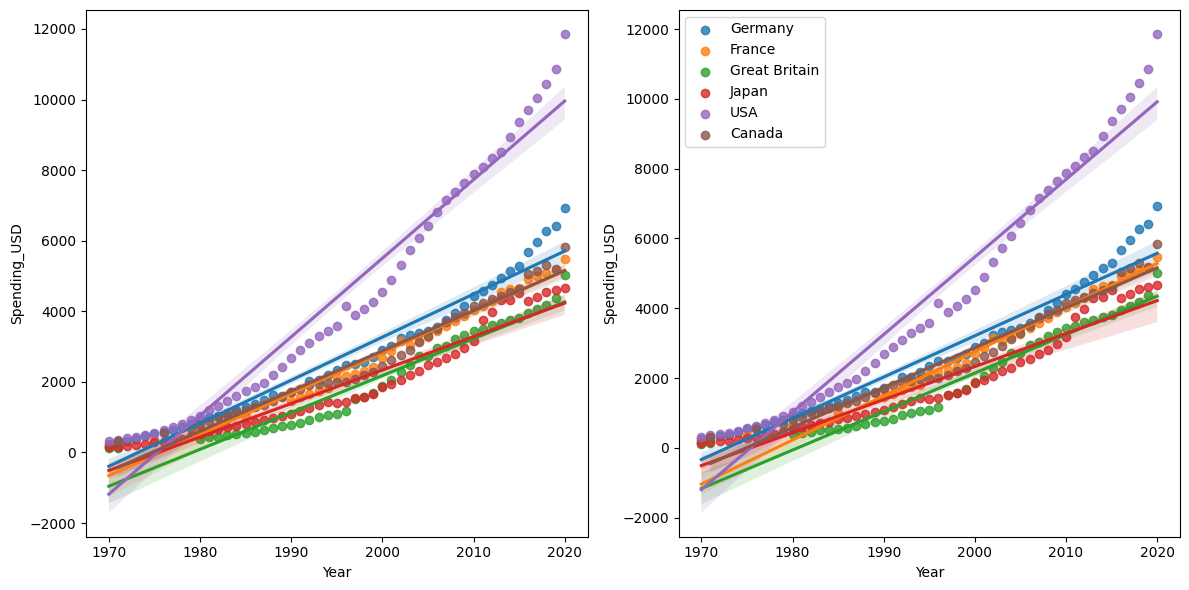

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,6))

ax = axs[0]

for country in healthexp['Country'].unique():
  mask = healthexp['Country'] == country
  sns.regplot(    data=healthexp[mask],
      x="Year", y="Spending_USD", ax=ax, label=country, robust=False,
  )

ax = axs[1]
for country in healthexp['Country'].unique():
  mask = healthexp['Country'] == country
  sns.regplot(    data=healthexp[mask],
      x="Year", y="Spending_USD", ax=ax, label=country, robust=True,
  )

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print("Theoretical method:")
for country in healthexp['Country'].unique():
  mask = healthexp['Country'] == country
  data = healthexp[mask]
  res = stats.linregress(data['Year'], data['Spending_USD'])
  df = len(data) - 2
  alfa = 0.05
  t_stat = stats.t.ppf(1-alfa/2, df)
  CI = (res.slope - t_stat * res.stderr).round(4), (res.slope + t_stat * res.stderr).round(4)
  print(f"\t{country} 95% CI: {CI}")


def fn(x, y):
  reg = stats.linregress(x, y)
  return reg.slope

print("Bootstrap method:")
for country in healthexp['Country'].unique():
  mask = healthexp['Country'] == country
  data = healthexp[mask]
  res = stats.bootstrap((data['Year'],data['Spending_USD']),fn ,paired=True)
  CI = res.confidence_interval.low.round(4),res.confidence_interval.high.round(4)
  print(f"\t{country} 95% CI: {CI}")



Theoretical method:
	Germany 95% CI: (114.3117, 129.686)
	France 95% CI: (109.3292, 123.0259)
	Great Britain 95% CI: (95.8115, 113.1297)
	Japan 95% CI: (86.986, 102.6828)
	USA 95% CI: (209.1599, 236.4143)
	Canada 95% CI: (107.1598, 120.4271)
Bootstrap method:
	Germany 95% CI: (112.8061, 132.8555)
	France 95% CI: (102.8939, 127.8718)
	Great Britain 95% CI: (90.9281, 116.2934)
	Japan 95% CI: (85.3451, 103.4073)
	USA 95% CI: (206.5801, 240.8382)
	Canada 95% CI: (104.825, 121.6281)


## Aspirin Impact

The impact of aspirine impact is often tested in mecidine ([heart diseases](https://www.ahajournals.org/doi/full/10.1161/01.str.29.5.887), [COVID mortality](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7834714/)).

Below we follow the example given by Efron to demonstrate how CI invalidate  impressions driven by point estimate.
From the data **it appears that aspirine is harmful**, which is **found false by considering confidence intervals** to account for uncertainty.

**Homework**: Proceed analogusly to reproduce estimates for risk ratios from Figure 1 in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7834714/

> NOTE: for explanations on falsely inteprepred cause-effects of aspirisine see https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704-ep713_confounding-em/BS704-EP713_Confounding-EM7.html

In [26]:
import pandas as pd

data = {
    "subjects": [11037, 11034],
    "stroke": [119, 98],
    "no stroke": [10918, 10936]
}

index = ["aspirin", "placebo"]

df = pd.DataFrame(data, index=index)
print(df)

         subjects  stroke  no stroke
aspirin     11037     119      10918
placebo     11034      98      10936


In [27]:
from statsmodels.stats.proportion import proportions_chisquare

_,pval,_ = proportions_chisquare( df["stroke"], df["subjects"])
assert pval >= 0.05

> Note: when comparing differences, rather than proportions, we expect CI ~ (-0.000703,0.004504), [see these slides](https://math.unm.edu/~luyan/ADA118/chap9.pdf)

In [ ]:
from scipy import stats

x_aspirin = np.concatenate([np.ones(df.loc["aspirin","stroke"]),np.zeros(df.loc["aspirin","no stroke"])])
x_placebo = np.concatenate([np.ones(df.loc["placebo","stroke"]),np.zeros(df.loc["placebo","no stroke"])])

def risk_ratio(x,y):
  return np.mean(x) / np.mean(y)

res = stats.bootstrap((x_aspirin, x_placebo),risk_ratio)
res.confidence_interval

ConfidenceInterval(low=0.9219795222260438, high=1.5904766611480394)